In [1]:
!pip install torch torchvision torchaudio librosa numpy scikit-learn matplotlib sounddevice transformers

In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00


In [3]:
!apt-get update  # Update package lists
!apt-get install -y portaudio19-dev  # Install PortAudio development package

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [70.9 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,688 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4,154 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,824 kB]
Get:13 https://ppa.launchpadcontent.net/graphic

In [4]:
import os
import numpy as np
import torch
import torchaudio
import torchaudio.transforms as T
import librosa
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import KFold
import evaluate
from datasets import DatasetDict, Dataset, Audio
import matplotlib.pyplot as plt
import sounddevice as sd
from tkinter import Tk
from tkinter.filedialog import askopenfilename

In [5]:

# Paths and dataset structure
DATASET_PATH = "/kaggle/input/audio-data/Audio_Data"
SPLITS = ["training", "validation", "testing"]
CATEGORIES = ["real", "fake"]
SAMPLE_FRACTION = 0.1  # Use 10% of each split

In [6]:
# Step 4: Set Device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# Audio augmentation function
def augment_audio(waveform, sample_rate=16000):
    effects = [
        T.PitchShift(sample_rate=sample_rate, n_steps=np.random.uniform(-2, 2)),
        lambda x: x + torch.randn_like(x) * 0.01  # Simplified noise addition
    ]
    for effect in effects:
        if np.random.rand() > 0.5:  # Randomly apply
            waveform = effect(waveform)
    return waveform

In [8]:
# Load audio with error handling
def load_audio(file_path, target_sample_rate=16000, max_length=5*16000):
    try:
        waveform, sr = torchaudio.load(file_path)
        if sr != target_sample_rate:
            waveform = T.Resample(sr, target_sample_rate)(waveform)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        if waveform.shape[1] > max_length:
            waveform = waveform[:, :max_length]
        elif waveform.shape[1] < max_length:
            waveform = torch.nn.functional.pad(waveform, (0, max_length - waveform.shape[1]))
        return waveform.squeeze(0)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        waveform, _ = librosa.load(file_path, sr=target_sample_rate, mono=True)
        waveform = torch.tensor(waveform)
        if len(waveform) > max_length:
            waveform = waveform[:max_length]
        elif len(waveform) < max_length:
            waveform = torch.nn.functional.pad(waveform, (0, max_length - len(waveform)))
        return waveform

In [9]:
# Compute global spectrogram stats for consistent normalization
def compute_global_stats(dataset_split):
    all_specs = [audio_to_spectrogram(load_audio(x["audio"]["path"]), normalize=False) for x in dataset_split]
    all_specs = torch.stack(all_specs)
    return all_specs.min(), all_specs.max()

In [10]:
# Updated spectrogram conversion with global normalization
def audio_to_spectrogram(waveform, sample_rate=16000, n_mels=128, n_fft=2048, hop_length=512, target_size=(299, 299), normalize=True):
    if isinstance(waveform, np.ndarray):
        waveform = torch.tensor(waveform)
    if waveform.dim() > 1:
        waveform = waveform.mean(dim=0)

    mel_spec = T.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)(waveform)
    mel_spec_db = T.AmplitudeToDB()(mel_spec)

    if normalize and 'global_min' in globals() and 'global_max' in globals():
        mel_spec_db = (mel_spec_db - global_min) / (global_max - global_min)
        mel_spec_db = torch.clamp(mel_spec_db, 0, 1)
    else:
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())

    mel_spec_db = torch.nn.functional.interpolate(
        mel_spec_db.unsqueeze(0).unsqueeze(0), size=target_size, mode='bilinear', align_corners=False
    ).squeeze(0)
    mel_spec_db = mel_spec_db.repeat(3, 1, 1)
    return mel_spec_db

In [11]:
# Updated load_dataset_subset to use 10% of each split
def load_dataset_subset(root_dir, sample_fraction=SAMPLE_FRACTION):
    dataset_dict = {}
    for split in SPLITS:
        real_dir = os.path.join(root_dir, split, "real")
        fake_dir = os.path.join(root_dir, split, "fake")
        real_files = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith('.wav')]
        fake_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith('.wav')]

        if not real_files or not fake_files:
            print(f"Warning: Empty folder in {split}")
            continue

        # Take 10% of each class to maintain balance
        n_real = max(1, int(len(real_files) * sample_fraction))  # Ensure at least 1 sample
        n_fake = max(1, int(len(fake_files) * sample_fraction))

        # Randomly shuffle and select
        np.random.shuffle(real_files)
        np.random.shuffle(fake_files)

        subset_real = real_files[:n_real]
        subset_fake = fake_files[:n_fake]

        audio_files = subset_real + subset_fake
        labels = [0] * len(subset_real) + [1] * len(subset_fake)

        dataset = Dataset.from_dict({"audio": audio_files, "label": labels}).cast_column("audio", Audio(sampling_rate=16000))
        dataset_dict[split] = dataset

        print(f"{split} subset - Real: {len(subset_real)} ({len(subset_real)/len(audio_files):.2%}), "
              f"Fake: {len(subset_fake)} ({len(subset_fake)/len(audio_files):.2%}), Total: {len(audio_files)}")

    return DatasetDict(dataset_dict)

In [12]:
# Load and preprocess dataset
dataset = load_dataset_subset(DATASET_PATH)
print(f"Dataset subset loaded with sizes: { {split: len(dataset[split]) for split in SPLITS} }")

# Compute global stats for normalization
global_min, global_max = compute_global_stats(dataset["training"])

# Preprocess with augmentation for training
def preprocess_function(batch):
    waveforms = [load_audio(audio["path"]) for audio in batch["audio"]]
    if "training" in batch["audio"][0]["path"]:
        waveforms = [augment_audio(wf) for wf in waveforms]
    spectrograms = [audio_to_spectrogram(wf) for wf in waveforms]
    return {"input_values": spectrograms, "labels": batch["label"]}

for split in SPLITS:
    dataset[split] = dataset[split].map(
        preprocess_function, batched=True, batch_size=8, remove_columns=["audio"], desc=f"Preprocessing {split} subset"
    )


training subset - Real: 697 (50.00%), Fake: 697 (50.00%), Total: 1394
validation subset - Real: 141 (50.00%), Fake: 141 (50.00%), Total: 282
testing subset - Real: 55 (50.46%), Fake: 54 (49.54%), Total: 109
Dataset subset loaded with sizes: {'training': 1394, 'validation': 282, 'testing': 109}


Preprocessing training subset:   0%|          | 0/1394 [00:00<?, ? examples/s]

Preprocessing validation subset:   0%|          | 0/282 [00:00<?, ? examples/s]

Preprocessing testing subset:   0%|          | 0/109 [00:00<?, ? examples/s]

In [13]:
# Check class balance
for split in SPLITS:
    labels = dataset[split]["labels"]
    real_count = sum(1 for l in labels if l == 0)
    fake_count = sum(1 for l in labels if l == 1)
    print(f"{split} - Real: {real_count}, Fake: {fake_count}, Balance: {real_count/(real_count+fake_count):.2%}")

training - Real: 697, Fake: 697, Balance: 50.00%
validation - Real: 141, Fake: 141, Balance: 50.00%
testing - Real: 55, Fake: 54, Balance: 50.46%


In [14]:
# Load pre-trained models with fine-tuning adjustments
pretrained_inception_weights = models.Inception_V3_Weights.IMAGENET1K_V1.get_state_dict(progress=True)
inception = models.inception_v3(weights=None, aux_logits=False)
inception.load_state_dict({k: v for k, v in pretrained_inception_weights.items() if k in inception.state_dict()}, strict=False)
inception.fc = nn.Sequential(nn.Linear(inception.fc.in_features, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, 2))
for name, param in inception.named_parameters():
    if "Mixed_7" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
inception = inception.to(device)

mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
mobilenet.classifier = nn.Sequential(
    nn.Dropout(0.5), nn.Linear(mobilenet.last_channel, 512), nn.ReLU(), nn.Linear(512, 2)
)
for name, param in mobilenet.named_parameters():
    if "features.14" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
mobilenet = mobilenet.to(device)

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg16.classifier = nn.Sequential(
    *vgg16.classifier[:-1], nn.Dropout(0.5), nn.Linear(vgg16.classifier[-1].in_features, 512), nn.ReLU(), nn.Linear(512, 2)
)
for name, param in vgg16.named_parameters():
    if "features.24" in name or "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
vgg16 = vgg16.to(device)

models_dict = {"InceptionNet": inception, "MobileNet": mobilenet, "VGG16": vgg16}

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 287MB/s] 
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 121MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 228MB/s]


In [15]:
# DataLoader creation
def create_dataloader(dataset_split, batch_size=32, shuffle=True):
    inputs = torch.stack([torch.tensor(x["input_values"]) for x in dataset_split])
    labels = torch.tensor([x["labels"] for x in dataset_split])
    tensor_dataset = TensorDataset(inputs, labels)
    return DataLoader(tensor_dataset, batch_size=batch_size, shuffle=shuffle)

In [16]:
# Metrics computation
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(logits, labels):
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels)
    recall = recall_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

In [17]:
# Plot training history
def plot_training_history(train_losses, val_accuracies, model_name):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Train Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} Val Accuracy")
    plt.legend()
    plt.show()

In [18]:
# Updated training function with scheduler, early stopping, and plotting
def train_model(model, train_loader, val_loader, epochs=20, learning_rate=1e-4, weight_decay=0.01, patience=5, model_name="Model"):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    criterion = nn.CrossEntropyLoss()
    train_losses, val_accuracies = [], []
    best_accuracy = 0.0
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        scheduler.step()
        model.eval()
        val_logits, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_logits.append(outputs.cpu().numpy())
                val_labels.append(labels.cpu().numpy())

        val_logits = np.concatenate(val_logits)
        val_labels = np.concatenate(val_labels)
        metrics = compute_metrics(val_logits, val_labels)

        train_losses.append(train_loss / len(train_loader))
        val_accuracies.append(metrics["accuracy"])
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Accuracy: {metrics['accuracy']:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

        if metrics["accuracy"] > best_accuracy:
            best_accuracy = metrics["accuracy"]
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    plot_training_history(train_losses, val_accuracies, model_name)
    return best_model_state, metrics


Training InceptionNet...

Training fold 1/5
Epoch 1/20 - Train Loss: 0.7046, Val Accuracy: 0.6452, LR: 0.000100
Epoch 2/20 - Train Loss: 0.5657, Val Accuracy: 0.7491, LR: 0.000100
Epoch 3/20 - Train Loss: 0.2648, Val Accuracy: 0.7455, LR: 0.000100
Epoch 4/20 - Train Loss: 0.0684, Val Accuracy: 0.8100, LR: 0.000100
Epoch 5/20 - Train Loss: 0.0410, Val Accuracy: 0.8029, LR: 0.000050
Epoch 6/20 - Train Loss: 0.0238, Val Accuracy: 0.8029, LR: 0.000050
Epoch 7/20 - Train Loss: 0.0123, Val Accuracy: 0.8065, LR: 0.000050
Epoch 8/20 - Train Loss: 0.0093, Val Accuracy: 0.7993, LR: 0.000050
Epoch 9/20 - Train Loss: 0.0064, Val Accuracy: 0.8208, LR: 0.000050
Epoch 10/20 - Train Loss: 0.0055, Val Accuracy: 0.8172, LR: 0.000025
Epoch 11/20 - Train Loss: 0.0060, Val Accuracy: 0.8315, LR: 0.000025
Epoch 12/20 - Train Loss: 0.0034, Val Accuracy: 0.8315, LR: 0.000025
Epoch 13/20 - Train Loss: 0.0029, Val Accuracy: 0.8315, LR: 0.000025
Epoch 14/20 - Train Loss: 0.0034, Val Accuracy: 0.8172, LR: 0.00002

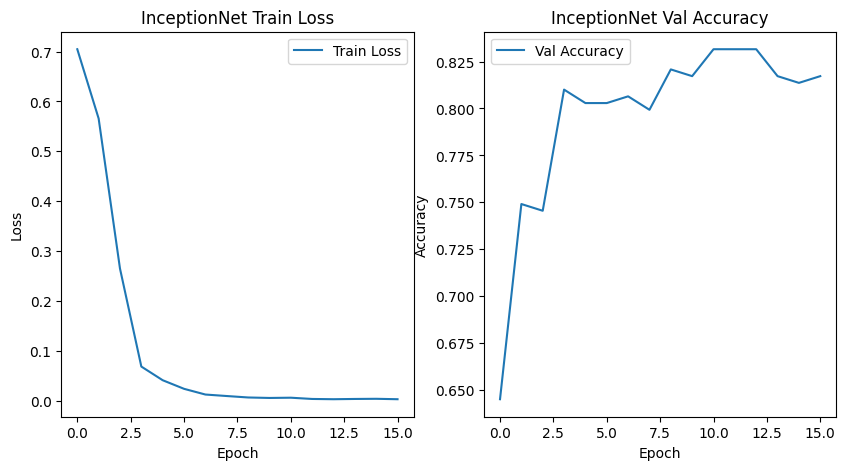

Fold 1 - Accuracy: 0.8172, Precision: 0.8112, Recall: 0.8286, F1: 0.8198

Training fold 2/5


/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoch 1/20 - Train Loss: 0.6981, Val Accuracy: 0.5878, LR: 0.000100
Epoch 2/20 - Train Loss: 0.5202, Val Accuracy: 0.7168, LR: 0.000100
Epoch 3/20 - Train Loss: 0.2295, Val Accuracy: 0.7527, LR: 0.000100
Epoch 4/20 - Train Loss: 0.0657, Val Accuracy: 0.7419, LR: 0.000100
Epoch 5/20 - Train Loss: 0.0280, Val Accuracy: 0.7599, LR: 0.000050
Epoch 6/20 - Train Loss: 0.0175, Val Accuracy: 0.7706, LR: 0.000050
Epoch 7/20 - Train Loss: 0.0094, Val Accuracy: 0.7670, LR: 0.000050
Epoch 8/20 - Train Loss: 0.0201, Val Accuracy: 0.7634, LR: 0.000050
Epoch 9/20 - Train Loss: 0.0120, Val Accuracy: 0.7599, LR: 0.000050
Epoch 10/20 - Train Loss: 0.0059, Val Accuracy: 0.7599, LR: 0.000025
Epoch 11/20 - Train Loss: 0.0060, Val Accuracy: 0.7706, LR: 0.000025
Early stopping at epoch 11


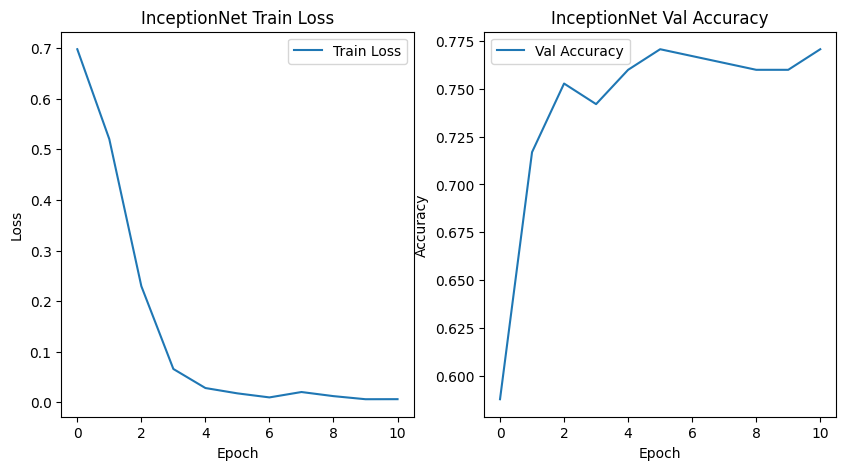

Fold 2 - Accuracy: 0.7706, Precision: 0.7923, Recall: 0.7357, F1: 0.7630

Training fold 3/5


/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoch 1/20 - Train Loss: 0.6776, Val Accuracy: 0.5771, LR: 0.000100
Epoch 2/20 - Train Loss: 0.5169, Val Accuracy: 0.7599, LR: 0.000100
Epoch 3/20 - Train Loss: 0.1858, Val Accuracy: 0.7706, LR: 0.000100
Epoch 4/20 - Train Loss: 0.0395, Val Accuracy: 0.8136, LR: 0.000100
Epoch 5/20 - Train Loss: 0.0236, Val Accuracy: 0.8172, LR: 0.000050
Epoch 6/20 - Train Loss: 0.0238, Val Accuracy: 0.8244, LR: 0.000050
Epoch 7/20 - Train Loss: 0.0138, Val Accuracy: 0.7921, LR: 0.000050
Epoch 8/20 - Train Loss: 0.0087, Val Accuracy: 0.8029, LR: 0.000050
Epoch 9/20 - Train Loss: 0.0125, Val Accuracy: 0.8065, LR: 0.000050
Epoch 10/20 - Train Loss: 0.0092, Val Accuracy: 0.8172, LR: 0.000025
Epoch 11/20 - Train Loss: 0.0075, Val Accuracy: 0.8208, LR: 0.000025
Early stopping at epoch 11


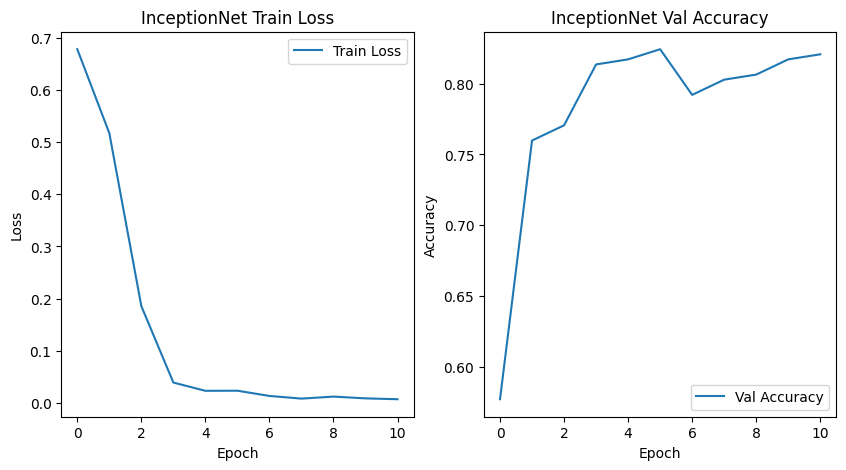

Fold 3 - Accuracy: 0.8208, Precision: 0.7842, Recall: 0.8450, F1: 0.8134

Training fold 4/5


/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoch 1/20 - Train Loss: 0.6819, Val Accuracy: 0.6308, LR: 0.000100
Epoch 2/20 - Train Loss: 0.4936, Val Accuracy: 0.7670, LR: 0.000100
Epoch 3/20 - Train Loss: 0.1960, Val Accuracy: 0.7778, LR: 0.000100
Epoch 4/20 - Train Loss: 0.0566, Val Accuracy: 0.7634, LR: 0.000100
Epoch 5/20 - Train Loss: 0.0290, Val Accuracy: 0.7742, LR: 0.000050
Epoch 6/20 - Train Loss: 0.0142, Val Accuracy: 0.7778, LR: 0.000050
Epoch 7/20 - Train Loss: 0.0088, Val Accuracy: 0.7778, LR: 0.000050
Epoch 8/20 - Train Loss: 0.0151, Val Accuracy: 0.7491, LR: 0.000050
Early stopping at epoch 8


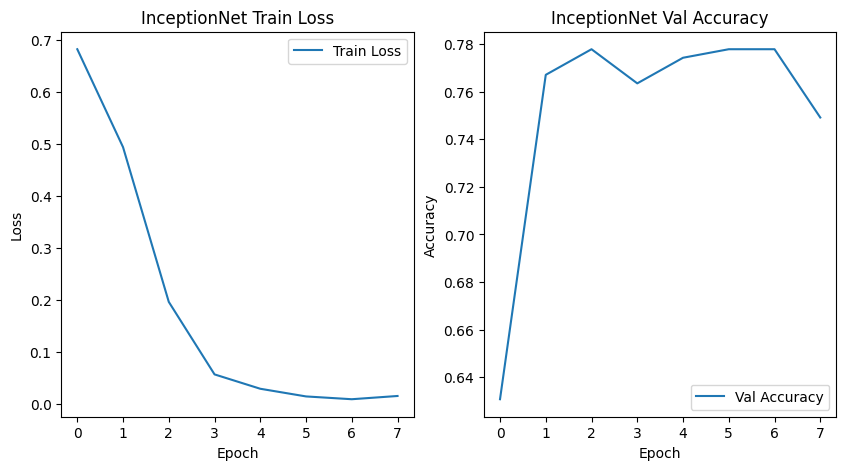

Fold 4 - Accuracy: 0.7491, Precision: 0.7710, Recall: 0.7163, F1: 0.7426

Training fold 5/5


/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoch 1/20 - Train Loss: 0.6744, Val Accuracy: 0.5647, LR: 0.000100
Epoch 2/20 - Train Loss: 0.4549, Val Accuracy: 0.7266, LR: 0.000100
Epoch 3/20 - Train Loss: 0.1672, Val Accuracy: 0.7482, LR: 0.000100
Epoch 4/20 - Train Loss: 0.0454, Val Accuracy: 0.7626, LR: 0.000100
Epoch 5/20 - Train Loss: 0.0355, Val Accuracy: 0.7698, LR: 0.000050
Epoch 6/20 - Train Loss: 0.0264, Val Accuracy: 0.8058, LR: 0.000050
Epoch 7/20 - Train Loss: 0.0133, Val Accuracy: 0.8094, LR: 0.000050
Epoch 8/20 - Train Loss: 0.0080, Val Accuracy: 0.8165, LR: 0.000050
Epoch 9/20 - Train Loss: 0.0082, Val Accuracy: 0.7914, LR: 0.000050
Epoch 10/20 - Train Loss: 0.0072, Val Accuracy: 0.7626, LR: 0.000025
Epoch 11/20 - Train Loss: 0.0082, Val Accuracy: 0.7842, LR: 0.000025
Epoch 12/20 - Train Loss: 0.0045, Val Accuracy: 0.7770, LR: 0.000025
Epoch 13/20 - Train Loss: 0.0034, Val Accuracy: 0.7698, LR: 0.000025
Early stopping at epoch 13


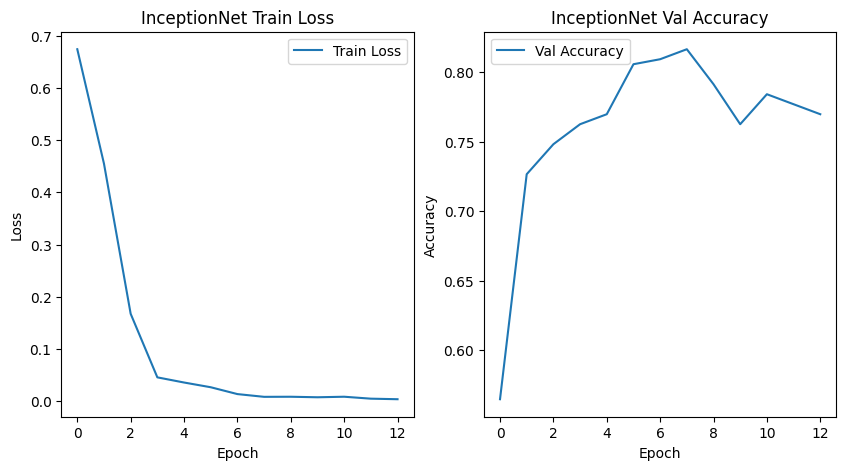

Fold 5 - Accuracy: 0.7698, Precision: 0.7943, Recall: 0.7619, F1: 0.7778

Cross-Validation Results for InceptionNet:
Average Accuracy: 0.7855
Average Precision: 0.7906
Average Recall: 0.7775
Average F1: 0.7833

Training MobileNet...

Training fold 1/5
Epoch 1/20 - Train Loss: 0.6921, Val Accuracy: 0.6344, LR: 0.000100
Epoch 2/20 - Train Loss: 0.6538, Val Accuracy: 0.6667, LR: 0.000100
Epoch 3/20 - Train Loss: 0.5962, Val Accuracy: 0.7384, LR: 0.000100
Epoch 4/20 - Train Loss: 0.5131, Val Accuracy: 0.7814, LR: 0.000100
Epoch 5/20 - Train Loss: 0.4510, Val Accuracy: 0.7491, LR: 0.000050
Epoch 6/20 - Train Loss: 0.3784, Val Accuracy: 0.8172, LR: 0.000050
Epoch 7/20 - Train Loss: 0.3355, Val Accuracy: 0.8136, LR: 0.000050
Epoch 8/20 - Train Loss: 0.3060, Val Accuracy: 0.8315, LR: 0.000050
Epoch 9/20 - Train Loss: 0.2692, Val Accuracy: 0.8280, LR: 0.000050
Epoch 10/20 - Train Loss: 0.2646, Val Accuracy: 0.8065, LR: 0.000025
Epoch 11/20 - Train Loss: 0.2274, Val Accuracy: 0.8244, LR: 0.00002

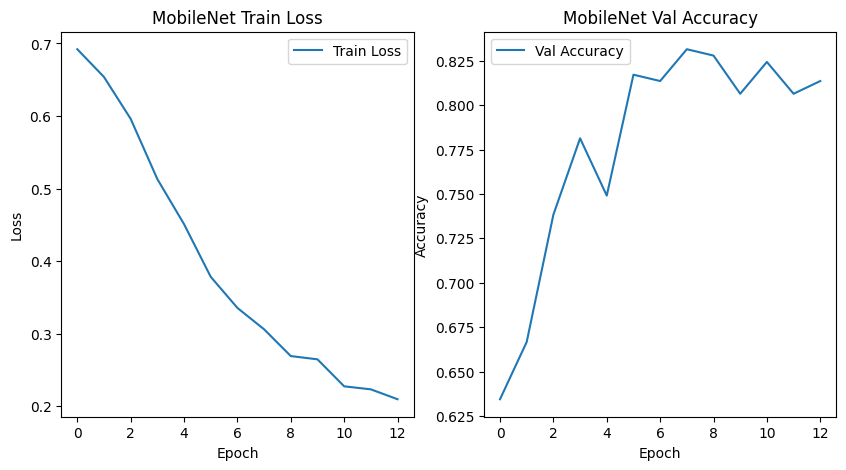

Fold 1 - Accuracy: 0.8136, Precision: 0.8099, Recall: 0.8214, F1: 0.8156

Training fold 2/5
Epoch 1/20 - Train Loss: 0.6890, Val Accuracy: 0.6022, LR: 0.000100
Epoch 2/20 - Train Loss: 0.6589, Val Accuracy: 0.6272, LR: 0.000100
Epoch 3/20 - Train Loss: 0.5928, Val Accuracy: 0.6272, LR: 0.000100
Epoch 4/20 - Train Loss: 0.5116, Val Accuracy: 0.7455, LR: 0.000100
Epoch 5/20 - Train Loss: 0.4278, Val Accuracy: 0.7455, LR: 0.000050
Epoch 6/20 - Train Loss: 0.3902, Val Accuracy: 0.7706, LR: 0.000050
Epoch 7/20 - Train Loss: 0.3526, Val Accuracy: 0.7563, LR: 0.000050
Epoch 8/20 - Train Loss: 0.3236, Val Accuracy: 0.7849, LR: 0.000050
Epoch 9/20 - Train Loss: 0.2924, Val Accuracy: 0.7849, LR: 0.000050
Epoch 10/20 - Train Loss: 0.2894, Val Accuracy: 0.7849, LR: 0.000025
Epoch 11/20 - Train Loss: 0.2388, Val Accuracy: 0.7849, LR: 0.000025
Epoch 12/20 - Train Loss: 0.2335, Val Accuracy: 0.7921, LR: 0.000025
Epoch 13/20 - Train Loss: 0.2319, Val Accuracy: 0.7814, LR: 0.000025
Epoch 14/20 - Train 

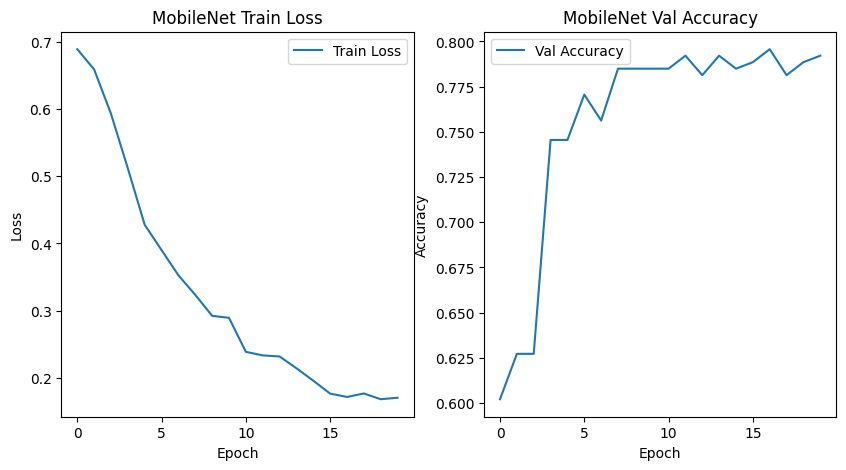

Fold 2 - Accuracy: 0.7921, Precision: 0.7971, Recall: 0.7857, F1: 0.7914

Training fold 3/5
Epoch 1/20 - Train Loss: 0.6950, Val Accuracy: 0.6380, LR: 0.000100
Epoch 2/20 - Train Loss: 0.6601, Val Accuracy: 0.6452, LR: 0.000100
Epoch 3/20 - Train Loss: 0.6228, Val Accuracy: 0.7133, LR: 0.000100
Epoch 4/20 - Train Loss: 0.5394, Val Accuracy: 0.7240, LR: 0.000100
Epoch 5/20 - Train Loss: 0.4600, Val Accuracy: 0.7527, LR: 0.000050
Epoch 6/20 - Train Loss: 0.3914, Val Accuracy: 0.7814, LR: 0.000050
Epoch 7/20 - Train Loss: 0.3543, Val Accuracy: 0.7742, LR: 0.000050
Epoch 8/20 - Train Loss: 0.3266, Val Accuracy: 0.7849, LR: 0.000050
Epoch 9/20 - Train Loss: 0.2922, Val Accuracy: 0.8208, LR: 0.000050
Epoch 10/20 - Train Loss: 0.2914, Val Accuracy: 0.7957, LR: 0.000025
Epoch 11/20 - Train Loss: 0.2655, Val Accuracy: 0.8100, LR: 0.000025
Epoch 12/20 - Train Loss: 0.2506, Val Accuracy: 0.7993, LR: 0.000025
Epoch 13/20 - Train Loss: 0.2283, Val Accuracy: 0.8172, LR: 0.000025
Epoch 14/20 - Train 

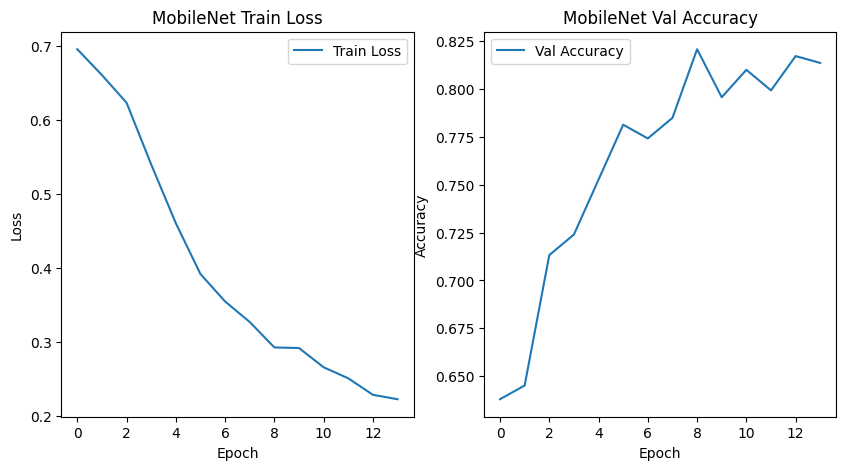

Fold 3 - Accuracy: 0.8136, Precision: 0.7939, Recall: 0.8062, F1: 0.8000

Training fold 4/5
Epoch 1/20 - Train Loss: 0.6984, Val Accuracy: 0.5161, LR: 0.000100
Epoch 2/20 - Train Loss: 0.6650, Val Accuracy: 0.7742, LR: 0.000100
Epoch 3/20 - Train Loss: 0.6090, Val Accuracy: 0.7706, LR: 0.000100
Epoch 4/20 - Train Loss: 0.5296, Val Accuracy: 0.7455, LR: 0.000100
Epoch 5/20 - Train Loss: 0.4657, Val Accuracy: 0.7993, LR: 0.000050
Epoch 6/20 - Train Loss: 0.3922, Val Accuracy: 0.8280, LR: 0.000050
Epoch 7/20 - Train Loss: 0.3582, Val Accuracy: 0.8172, LR: 0.000050
Epoch 8/20 - Train Loss: 0.3278, Val Accuracy: 0.8423, LR: 0.000050
Epoch 9/20 - Train Loss: 0.2878, Val Accuracy: 0.8351, LR: 0.000050
Epoch 10/20 - Train Loss: 0.2591, Val Accuracy: 0.8315, LR: 0.000025
Epoch 11/20 - Train Loss: 0.2597, Val Accuracy: 0.8280, LR: 0.000025
Epoch 12/20 - Train Loss: 0.2183, Val Accuracy: 0.8387, LR: 0.000025
Epoch 13/20 - Train Loss: 0.2197, Val Accuracy: 0.8387, LR: 0.000025
Early stopping at ep

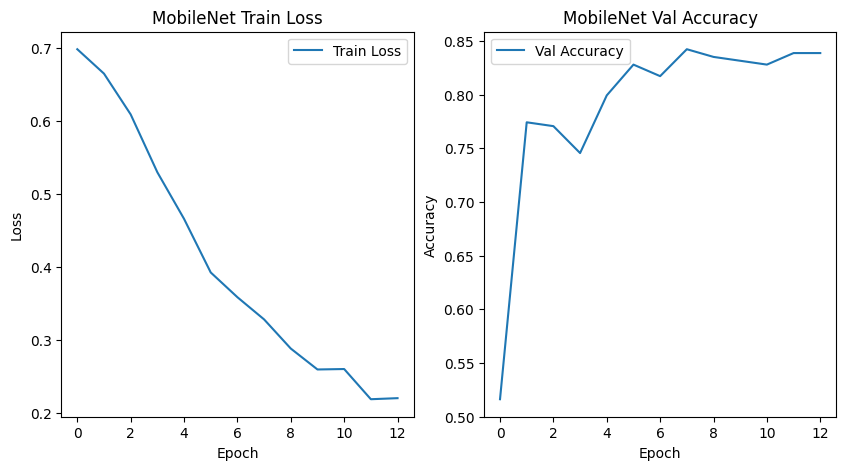

Fold 4 - Accuracy: 0.8387, Precision: 0.8529, Recall: 0.8227, F1: 0.8375

Training fold 5/5
Epoch 1/20 - Train Loss: 0.6825, Val Accuracy: 0.6763, LR: 0.000100
Epoch 2/20 - Train Loss: 0.6569, Val Accuracy: 0.6655, LR: 0.000100
Epoch 3/20 - Train Loss: 0.5875, Val Accuracy: 0.7230, LR: 0.000100
Epoch 4/20 - Train Loss: 0.5255, Val Accuracy: 0.7374, LR: 0.000100
Epoch 5/20 - Train Loss: 0.4410, Val Accuracy: 0.7554, LR: 0.000050
Epoch 6/20 - Train Loss: 0.3838, Val Accuracy: 0.8022, LR: 0.000050
Epoch 7/20 - Train Loss: 0.3477, Val Accuracy: 0.8094, LR: 0.000050
Epoch 8/20 - Train Loss: 0.3259, Val Accuracy: 0.7986, LR: 0.000050
Epoch 9/20 - Train Loss: 0.3001, Val Accuracy: 0.7842, LR: 0.000050
Epoch 10/20 - Train Loss: 0.2785, Val Accuracy: 0.7734, LR: 0.000025
Epoch 11/20 - Train Loss: 0.2440, Val Accuracy: 0.8022, LR: 0.000025
Epoch 12/20 - Train Loss: 0.2494, Val Accuracy: 0.8237, LR: 0.000025
Epoch 13/20 - Train Loss: 0.2214, Val Accuracy: 0.7950, LR: 0.000025
Epoch 14/20 - Train 

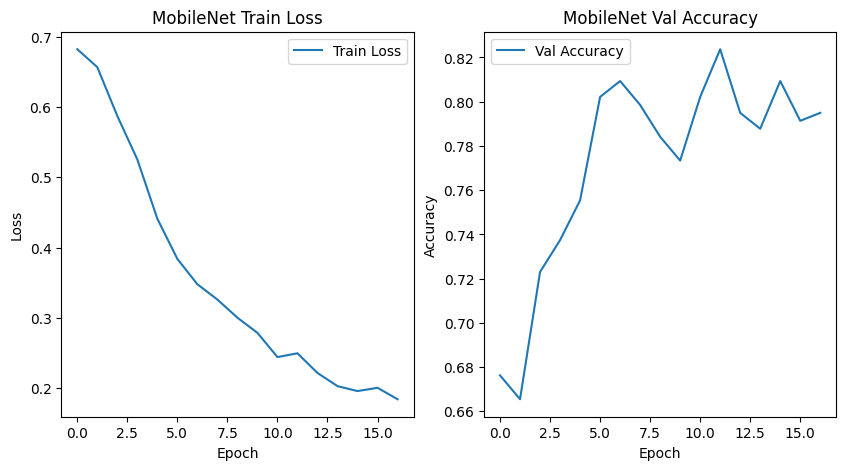

Fold 5 - Accuracy: 0.7950, Precision: 0.7885, Recall: 0.8367, F1: 0.8119

Cross-Validation Results for MobileNet:
Average Accuracy: 0.8106
Average Precision: 0.8085
Average Recall: 0.8146
Average F1: 0.8113

Training VGG16...

Training fold 1/5
Epoch 1/20 - Train Loss: 0.6895, Val Accuracy: 0.5054, LR: 0.000100
Epoch 2/20 - Train Loss: 0.6145, Val Accuracy: 0.5699, LR: 0.000100
Epoch 3/20 - Train Loss: 0.5002, Val Accuracy: 0.8351, LR: 0.000100
Epoch 4/20 - Train Loss: 0.3311, Val Accuracy: 0.8530, LR: 0.000100
Epoch 5/20 - Train Loss: 0.2396, Val Accuracy: 0.8459, LR: 0.000050
Epoch 6/20 - Train Loss: 0.1057, Val Accuracy: 0.8530, LR: 0.000050
Epoch 7/20 - Train Loss: 0.0589, Val Accuracy: 0.8674, LR: 0.000050
Epoch 8/20 - Train Loss: 0.0249, Val Accuracy: 0.8602, LR: 0.000050
Epoch 9/20 - Train Loss: 0.0161, Val Accuracy: 0.8674, LR: 0.000050
Epoch 10/20 - Train Loss: 0.0092, Val Accuracy: 0.8889, LR: 0.000025
Epoch 11/20 - Train Loss: 0.0081, Val Accuracy: 0.8817, LR: 0.000025
Epoch

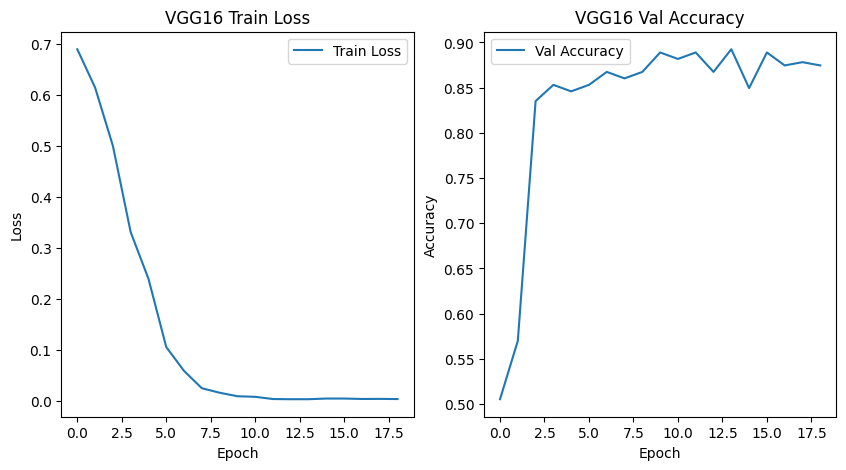

Fold 1 - Accuracy: 0.8746, Precision: 0.9200, Recall: 0.8214, F1: 0.8679

Training fold 2/5
Epoch 1/20 - Train Loss: 0.5384, Val Accuracy: 0.7025, LR: 0.000100
Epoch 2/20 - Train Loss: 0.3434, Val Accuracy: 0.8100, LR: 0.000100
Epoch 3/20 - Train Loss: 0.2114, Val Accuracy: 0.8100, LR: 0.000100
Epoch 4/20 - Train Loss: 0.0975, Val Accuracy: 0.8065, LR: 0.000100
Epoch 5/20 - Train Loss: 0.0714, Val Accuracy: 0.8172, LR: 0.000050
Epoch 6/20 - Train Loss: 0.0338, Val Accuracy: 0.8530, LR: 0.000050
Epoch 7/20 - Train Loss: 0.0108, Val Accuracy: 0.8674, LR: 0.000050
Epoch 8/20 - Train Loss: 0.0067, Val Accuracy: 0.8530, LR: 0.000050
Epoch 9/20 - Train Loss: 0.0048, Val Accuracy: 0.8674, LR: 0.000050
Epoch 10/20 - Train Loss: 0.0059, Val Accuracy: 0.8566, LR: 0.000025
Epoch 11/20 - Train Loss: 0.0048, Val Accuracy: 0.8530, LR: 0.000025
Epoch 12/20 - Train Loss: 0.0031, Val Accuracy: 0.8602, LR: 0.000025
Early stopping at epoch 12


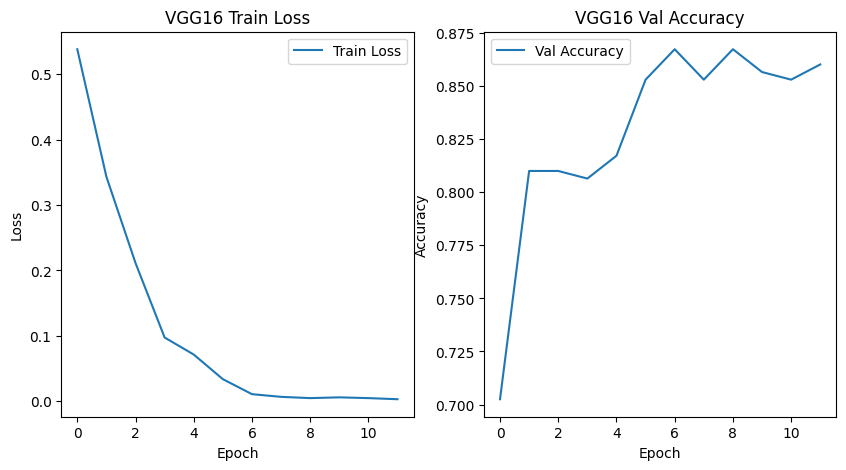

Fold 2 - Accuracy: 0.8602, Precision: 0.8531, Recall: 0.8714, F1: 0.8622

Training fold 3/5
Epoch 1/20 - Train Loss: 0.5581, Val Accuracy: 0.8351, LR: 0.000100
Epoch 2/20 - Train Loss: 0.3275, Val Accuracy: 0.8674, LR: 0.000100
Epoch 3/20 - Train Loss: 0.1629, Val Accuracy: 0.8710, LR: 0.000100
Epoch 4/20 - Train Loss: 0.1218, Val Accuracy: 0.8889, LR: 0.000100
Epoch 5/20 - Train Loss: 0.0404, Val Accuracy: 0.8746, LR: 0.000050
Epoch 6/20 - Train Loss: 0.0185, Val Accuracy: 0.8925, LR: 0.000050
Epoch 7/20 - Train Loss: 0.0098, Val Accuracy: 0.8853, LR: 0.000050
Epoch 8/20 - Train Loss: 0.0073, Val Accuracy: 0.8710, LR: 0.000050
Epoch 9/20 - Train Loss: 0.0066, Val Accuracy: 0.8853, LR: 0.000050
Epoch 10/20 - Train Loss: 0.0055, Val Accuracy: 0.8889, LR: 0.000025
Epoch 11/20 - Train Loss: 0.0048, Val Accuracy: 0.8925, LR: 0.000025
Early stopping at epoch 11


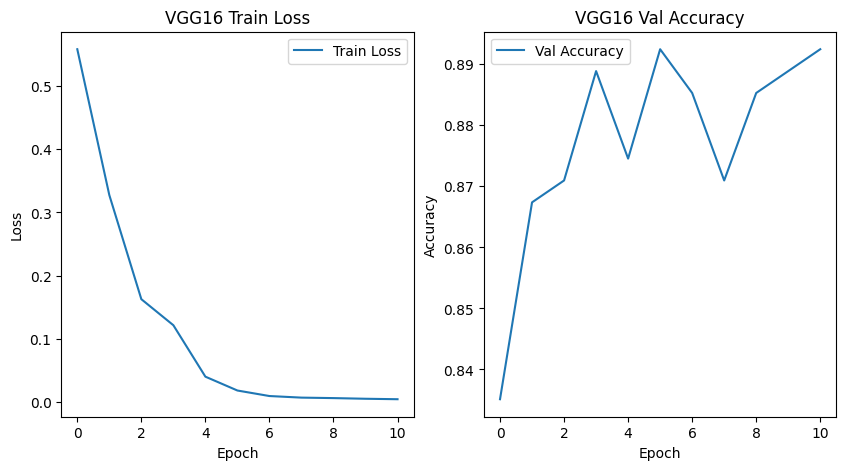

Fold 3 - Accuracy: 0.8925, Precision: 0.8722, Recall: 0.8992, F1: 0.8855

Training fold 4/5
Epoch 1/20 - Train Loss: 0.4804, Val Accuracy: 0.8602, LR: 0.000100
Epoch 2/20 - Train Loss: 0.2650, Val Accuracy: 0.8746, LR: 0.000100
Epoch 3/20 - Train Loss: 0.1149, Val Accuracy: 0.9104, LR: 0.000100
Epoch 4/20 - Train Loss: 0.0657, Val Accuracy: 0.8710, LR: 0.000100
Epoch 5/20 - Train Loss: 0.0475, Val Accuracy: 0.9068, LR: 0.000050
Epoch 6/20 - Train Loss: 0.0456, Val Accuracy: 0.9068, LR: 0.000050
Epoch 7/20 - Train Loss: 0.0095, Val Accuracy: 0.9247, LR: 0.000050
Epoch 8/20 - Train Loss: 0.0066, Val Accuracy: 0.9211, LR: 0.000050
Epoch 9/20 - Train Loss: 0.0071, Val Accuracy: 0.9247, LR: 0.000050
Epoch 10/20 - Train Loss: 0.0064, Val Accuracy: 0.9104, LR: 0.000025
Epoch 11/20 - Train Loss: 0.0038, Val Accuracy: 0.9104, LR: 0.000025
Epoch 12/20 - Train Loss: 0.0033, Val Accuracy: 0.9104, LR: 0.000025
Early stopping at epoch 12


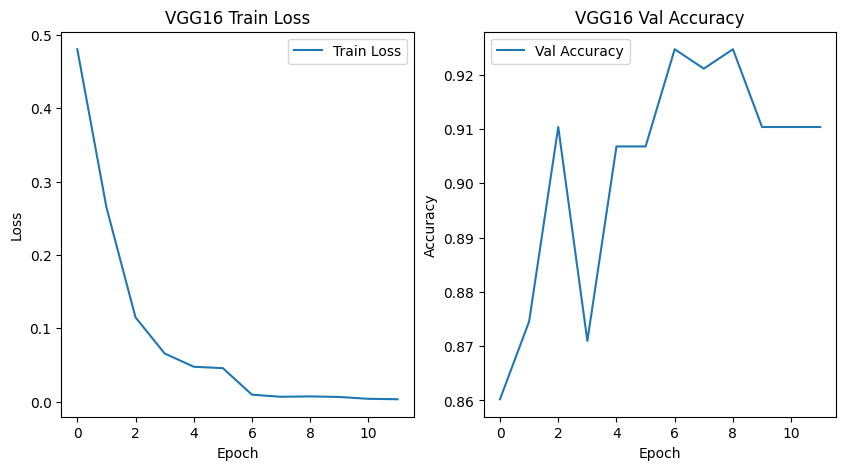

Fold 4 - Accuracy: 0.9104, Precision: 0.8867, Recall: 0.9433, F1: 0.9141

Training fold 5/5
Epoch 1/20 - Train Loss: 0.4456, Val Accuracy: 0.8849, LR: 0.000100
Epoch 2/20 - Train Loss: 0.2020, Val Accuracy: 0.9101, LR: 0.000100
Epoch 3/20 - Train Loss: 0.0952, Val Accuracy: 0.9029, LR: 0.000100
Epoch 4/20 - Train Loss: 0.0668, Val Accuracy: 0.8957, LR: 0.000100
Epoch 5/20 - Train Loss: 0.0272, Val Accuracy: 0.9137, LR: 0.000050
Epoch 6/20 - Train Loss: 0.0170, Val Accuracy: 0.8993, LR: 0.000050
Epoch 7/20 - Train Loss: 0.0076, Val Accuracy: 0.9137, LR: 0.000050
Epoch 8/20 - Train Loss: 0.0071, Val Accuracy: 0.9353, LR: 0.000050
Epoch 9/20 - Train Loss: 0.0070, Val Accuracy: 0.9137, LR: 0.000050
Epoch 10/20 - Train Loss: 0.0049, Val Accuracy: 0.9173, LR: 0.000025
Epoch 11/20 - Train Loss: 0.0034, Val Accuracy: 0.9101, LR: 0.000025
Epoch 12/20 - Train Loss: 0.0048, Val Accuracy: 0.9173, LR: 0.000025
Epoch 13/20 - Train Loss: 0.0046, Val Accuracy: 0.9209, LR: 0.000025
Early stopping at ep

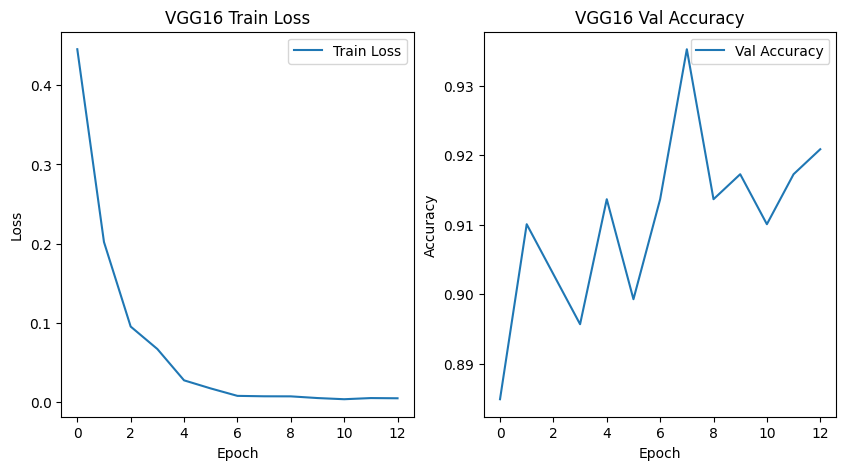

Fold 5 - Accuracy: 0.9209, Precision: 0.9252, Recall: 0.9252, F1: 0.9252

Cross-Validation Results for VGG16:
Average Accuracy: 0.8917
Average Precision: 0.8914
Average Recall: 0.8921
Average F1: 0.8910


In [19]:
# Cross-validation and training loop
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for model_name, model in models_dict.items():
    print(f"\nTraining {model_name}...")
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s = [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset["training"])):
        print(f"\nTraining fold {fold + 1}/{n_splits}")
        train_fold = dataset["training"].select(train_idx)
        val_fold = dataset["training"].select(val_idx)

        # Reinitialize model
        if model_name == "InceptionNet":
            model = models.inception_v3(weights=None, aux_logits=False)
            model.load_state_dict({k: v for k, v in pretrained_inception_weights.items() if k in model.state_dict()}, strict=False)
            model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, 2))
            for name, param in model.named_parameters():
                if "Mixed_7" in name or "fc" in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        elif model_name == "MobileNet":
            model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
            model.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.last_channel, 512), nn.ReLU(), nn.Linear(512, 2))
            for name, param in model.named_parameters():
                if "features.14" in name or "classifier" in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        elif model_name == "VGG16":
            model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
            model.classifier = nn.Sequential(
                *vgg16.classifier[:-1], nn.Dropout(0.5), nn.Linear(vgg16.classifier[-1].in_features, 512), nn.ReLU(), nn.Linear(512, 2)
            )
            for name, param in model.named_parameters():
                if "features.24" in name or "classifier" in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        model = model.to(device)

        train_loader = create_dataloader(train_fold, batch_size=32, shuffle=True)
        val_loader = create_dataloader(val_fold, batch_size=32, shuffle=False)

        best_model_state, eval_results = train_model(model, train_loader, val_loader, model_name=model_name)

        cv_accuracies.append(eval_results["accuracy"])
        cv_precisions.append(eval_results["precision"])
        cv_recalls.append(eval_results["recall"])
        cv_f1s.append(eval_results["f1"])

        print(f"Fold {fold + 1} - Accuracy: {eval_results['accuracy']:.4f}, "
              f"Precision: {eval_results['precision']:.4f}, "
              f"Recall: {eval_results['recall']:.4f}, "
              f"F1: {eval_results['f1']:.4f}")

    print(f"\nCross-Validation Results for {model_name}:")
    print(f"Average Accuracy: {np.mean(cv_accuracies):.4f}")
    print(f"Average Precision: {np.mean(cv_precisions):.4f}")
    print(f"Average Recall: {np.mean(cv_recalls):.4f}")
    print(f"Average F1: {np.mean(cv_f1s):.4f}")

In [20]:
# Load best model state and evaluate on test set
model.load_state_dict(best_model_state)
test_loader = create_dataloader(dataset["testing"], batch_size=32, shuffle=False)
model.eval()
test_logits, test_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_logits.append(outputs.cpu().numpy())  # Keep as list
        test_labels.append(labels.cpu().numpy())   # Keep as list
test_logits = np.concatenate(test_logits)  # Concatenate at the end
test_labels = np.concatenate(test_labels)  # Concatenate at the end
test_metrics = compute_metrics(test_logits, test_labels)

print(f"\nTest Results for {model_name}:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")


Test Results for VGG16:
Accuracy: 0.8349
Precision: 0.7571
Recall: 0.9815
F1 Score: 0.8548
